In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import talib as ta
import talib.abstract as ta
import pandas_ta as pta
from technical import qtpylib


In [2]:
df_1h = pd.read_json('/bali/freqtrade/user_data/data/binance/futures/ETH_USDT-1h-futures.json')
df_1h.columns = ['date', 'open', 'high', 'low', 'close', 'volume']
df_1h['date'] = df_1h.date.apply(lambda x: pd.to_datetime(x, unit='ms'))

In [13]:
df_15m = pd.read_json('/bali/freqtrade/user_data/data/binance/futures/ETH_USDT-15m-futures.json')
df_15m.columns = ['date', 'open', 'high', 'low', 'close', 'volume']
df_15m['date'] = df_15m.date.apply(lambda x: pd.to_datetime(x, unit='ms'))

In [6]:
df = pd.read_json('/bali/freqtrade/user_data/data/binance/futures/ETH_USDT-1m-futures.json')
df.columns = ['date', 'open', 'high', 'low', 'close', 'volume']
df['date'] = df.date.apply(lambda x: pd.to_datetime(x, unit='ms'))

In [3]:
df_1h

,date,open,high,low,close,volume
0,2019-11-27 07:00:00,146.00,146.00,146.00,146.00,0.010
1,2019-11-27 08:00:00,125.03,145.01,125.03,133.00,0.080
2,2019-11-27 09:00:00,133.00,133.00,133.00,133.00,0.000
3,2019-11-27 10:00:00,142.20,144.52,142.10,142.62,2832.710
4,2019-11-27 11:00:00,142.70,146.92,142.22,146.58,9079.800
...,...,...,...,...,...,...
25601,2022-10-29 00:00:00,1553.80,1556.85,1546.71,1552.70,110913.957
25602,2022-10-29 01:00:00,1552.70,1556.00,1551.32,1552.82,55779.297
25603,2022-10-29 02:00:00,1552.82,1578.00,1551.72,1571.44,303472.146
25604,2022-10-29 03:00:00,1571.45,1595.00,1568.06,1588.84,472058.893


In [4]:
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Activation, Flatten, Conv1D, MaxPooling1D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam, SGD, RMSprop, Adagrad, Adadelta, Adamax, Nadam, Ftrl
from keras import backend as K
from numpy import hstack
from sklearn.model_selection import train_test_split


2022-10-29 11:23:35.766411: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-29 11:23:35.912933: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-29 11:23:35.912955: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-29 11:23:35.945907: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-29 11:23:36.621934: W tensorflow/stream_executor/pla

In [5]:
# df_1h
n_input = 30
open = df_1h.open.values.reshape((len(df_1h.open.values), 1))
high = df_1h.high.values.reshape((len(df_1h.high.values), 1))
low = df_1h.low.values.reshape((len(df_1h.low.values), 1))
close = df_1h.close.values.reshape((len(df_1h.close.values), 1))
volume = df_1h.volume.values.reshape((len(df_1h.volume.values), 1))
features = hstack((open, high, low, close, volume))
generator = TimeseriesGenerator(features, close, length=n_input, batch_size=1)

# specify the model

# generator = TimeseriesGenerator(df_1h.close, df_1h.close, length= n_input, sampling_rate=1, batch_size=1)
# print(generator[0])

In [6]:
X = []
y = []
# train split
for i in range(len(generator)):
    X.append(generator[i][0])
    y.append(generator[i][1])
X = np.array(X)
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(20460, 1, 30, 5) (20460, 1, 1) (5116, 1, 30, 5) (5116, 1, 1)


In [7]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[-2], X_train.shape[-1]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[-2], X_test.shape[-1]))
y_train = y_train.reshape(y_train.shape[0], -1)
y_test = y_test.reshape(y_test.shape[0], -1)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(20460, 30, 5) (20460, 1) (5116, 30, 5) (5116, 1)


In [210]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(20482, 3, 5) (20482, 1) (5121, 3, 5) (5121, 1)


In [13]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_input, 5)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()
model.fit(X_train, y_train, epochs=100, verbose=1, validation_data=(X_test, y_test), workers=4, use_multiprocessing=True)



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50)                11200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 11,251
Trainable params: 11,251
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
640/640 [==============================] - 8s 11ms/step - loss: 102462000.0000 - val_loss: 30771256.0000
Epoch 2/100
640/640 [==============================] - 7s 11ms/step - loss: 4088236.7500 - val_loss: 15343232.0000
Epoch 3/100
640/640 [==============================] - 7s 11ms/step - loss: 2890495.0000 - val_loss: 13753588.0000
Epoch 4/100
640/640 [==============================] - 7s 11ms/step - loss: 2754574.0000 - val_loss

63/63 [==============================] - 0s 3ms/step


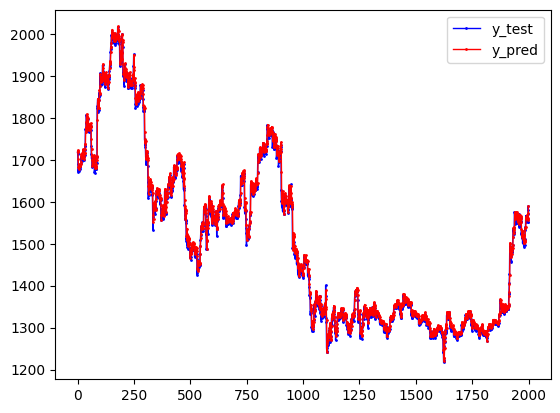

In [23]:
X_test_plt = X_test[-2000:]
y_test_plt = y_test[-2000:]
y_pred = model.predict(X_test_plt)
plt.plot(y_test_plt, label='y_test', color='blue',  linewidth=1, linestyle='solid', marker='o', markersize=1, markerfacecolor='blue', markeredgecolor='blue', markeredgewidth=1, alpha=1, zorder=1)
plt.plot(y_pred, label='y_pred', color='red',  linewidth=1, linestyle='solid', marker='o', markersize=1, markerfacecolor='red', markeredgecolor='red', markeredgewidth=1, alpha=1, zorder=1)
plt.legend()
plt.show()


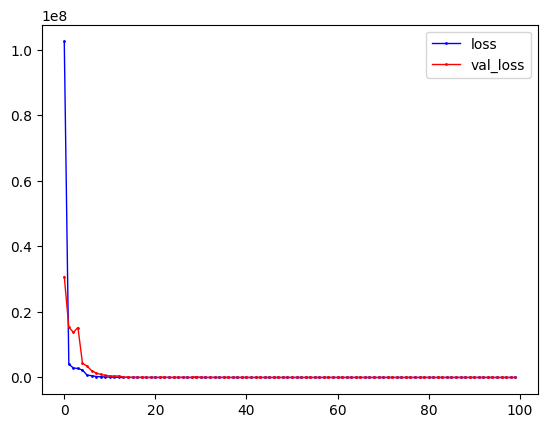

In [15]:
plt.plot(model.history.history['loss'], label='loss', color='blue',  linewidth=1, linestyle='solid', marker='o', markersize=1, markerfacecolor='blue', markeredgecolor='blue', markeredgewidth=1, alpha=1, zorder=1)
plt.plot(model.history.history['val_loss'], label='val_loss', color='red',  linewidth=1, linestyle='solid', marker='o', markersize=1, markerfacecolor='red', markeredgecolor='red', markeredgewidth=1, alpha=1, zorder=1)
plt.legend()
plt.show()

In [22]:
loss = model.evaluate(X_test, y_test, verbose=1)

160/160 [==============================] - 1s 3ms/step - loss: 352.7296


In [24]:
model.save('lstm_model_1029.h5')

In [26]:
ls

01_the_machine_learning_landscape.ipynb
02_end_to_end_machine_learning_project.ipynb
03_classification.ipynb
04_training_linear_models.ipynb
05_support_vector_machines.ipynb
06_decision_trees.ipynb
07_ensemble_learning_and_random_forests.ipynb
08_dimensionality_reduction.ipynb
09_unsupervised_learning.ipynb
10_neural_nets_with_keras.ipynb
11_training_deep_neural_networks.ipynb
12_custom_models_and_training_with_tensorflow.ipynb
13_loading_and_preprocessing_data.ipynb
14_deep_computer_vision_with_cnns.ipynb
15_processing_sequences_using_rnns_and_cnns.ipynb
16_nlp_with_rnns_and_attention.ipynb
17_autoencoders_gans_and_diffusion_models.ipynb
18_reinforcement_learning.ipynb
19_training_and_deploying_at_scale.ipynb
CHANGES.md
ETH_USDT-1h-futures.json
INSTALL.md
LICENSE
README.md
apt.txt
awd.py
book_equations.pdf
booknote.ipynb
data.json
docker/
environment.yml
extra_autodiff.ipynb
extra_gradient_descent_comparison.ipynb
feat_select.py
features.ipynb
images/
index.ipynb
lstm_model_1029.h5
ma